In [1]:
import pandas as pd
import numpy as np
import csv
from copy import deepcopy
from pandas import datetime
import gc
import datetime
import sys
sys.path.append('/home/ndsviriden/Minimax94/src/utils')  
from Downloader import Extractor
from Preprocessing import Preprocessor, set_onelevel, set_multilevel
from os import listdir
from os.path import isfile, join, isdir
from tqdm import tqdm_notebook
 
import matplotlib.pyplot as plt

In [2]:
mypath = '/home/ndsviriden/Minimax94/data/data_csv/Raw'
station_files = [int(f.split('_', 1)[0]) for f in listdir(mypath) if isfile(join(mypath, f)) if int(f.split('_', 1)[0])]
station_files.sort()
print(station_files)

[112, 113, 114, 115, 116, 117, 118, 119, 126, 129, 150, 152, 189, 200, 202, 204, 207, 223, 228, 239, 292, 293, 294, 295, 302, 305, 308, 309, 397, 401, 407, 411, 432, 435, 454, 456, 590, 593, 615, 626, 628, 635, 702, 704, 860, 865, 867, 870, 873, 879, 882, 895, 898, 1068, 1074, 1081, 1801, 1804, 1805, 1808, 1813, 1820, 1821, 1825, 1826, 1831, 1899, 1911, 1921, 1926, 1937, 20301, 20305, 20320, 20323, 20501, 20504, 20508, 20510, 20516, 20520, 20521, 20525, 20529, 20536, 20544, 20609, 20614, 20622, 20627, 20713, 20717, 20730, 20733, 20743, 20754, 20755, 20761, 20824, 20825, 20830, 20916, 20921]


In [3]:
station=112
# reading loaded csv files from data_csv directory, output is a list (length=number of stations) of raw df 
raw_data = pd.read_csv(mypath + '/' + str(station) + '_raw.csv', usecols=['id', 'date_time', 'data', 'type'], 
                        dtype={'station_id': int}, parse_dates = True)

sensor_type = 't_air'
raw_data = raw_data[raw_data['type'] == sensor_type]
raw_data.dropna(inplace=True)

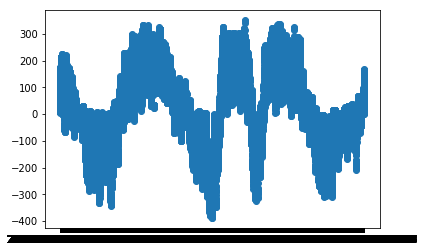

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot_date(raw_data.date_time, raw_data['data'])
plt.show()

In [1]:
# getting file tree in directory "data_csv", which contains raw unfiltered data
mypath = '/home/ndsviriden/data_csv/Raw'
dateparse = pd.to_datetime
station_files = [f for f in listdir(mypath) if isfile(join(mypath, f)) if int(f.split('_', 1)[0])]
station_files.sort()
station_files

# reading loaded csv files from data_csv directory, output is a list (length=number of stations) of raw df 
raw_lmeteo_list = [pd.read_csv(mypath + '/' + station, index_col=0, 
                    dtype={'station_id': int,'date_time': str}, 
                    date_parser = dateparse, parse_dates = ['date_time']) 
                   for station in tqdm_notebook(station_files[10:20])]

#fix problems with indexing, later this will be solved in loading part
for elem in raw_lmeteo_list:
    elem.reset_index(drop=True, inplace=True)

raw_data = pd.concat(raw_lmeteo_list)
raw_data['id'] = random.sample(range(len(raw_data)), len(raw_data))
raw_data['valid'] = True
raw_data = raw_data.reset_index(drop=True)

del raw_lmeteo_list
gc.collect()

raw_data

NameError: name 'pd' is not defined

In [4]:
preprocessor = Preprocessor()
meteo_split = preprocessor.PivotTable(raw_data)
meteo_split = preprocessor.FixPressureScale(meteo_split)
#patterns_list = preprocessor.CreatePatternList(meteo_split)
#patterns_interpolated = preprocessor.InterpolatePatterns(patterns_list)

In [5]:
z = deepcopy(meteo_split)

In [6]:
clean_data = []

In [6]:
def plot_data(df, station, start='2012-01-01', end='2016-01-01', sensor='t_air'):
    # selecting the exact station and time interval
    df_plot = df[df['station_id'] == station]
    df_plot = df_plot[(df_plot['date_time'] >= start) & (df_plot['date_time'] <= end)]

    plt.figure(figsize=(30, 10))
    plt.plot_date(df_plot.date_time, df_plot[('data', sensor)], 'b',
                      linestyle='none', marker='o', label=sensor, markersize=6)

    plt.title(sensor, fontsize=24)
    plt.legend(loc='upper right', fontsize=14)
    plt.grid(which='both')
    plt.show()
    pass

In [7]:
z.station_id.unique()

array([ 302,  303,  304,  305,  306,  307,  308,  309,  393,  442,  470,
        502,  503,  504,  505,  506, 1835, 1836, 1838, 1896, 1899])

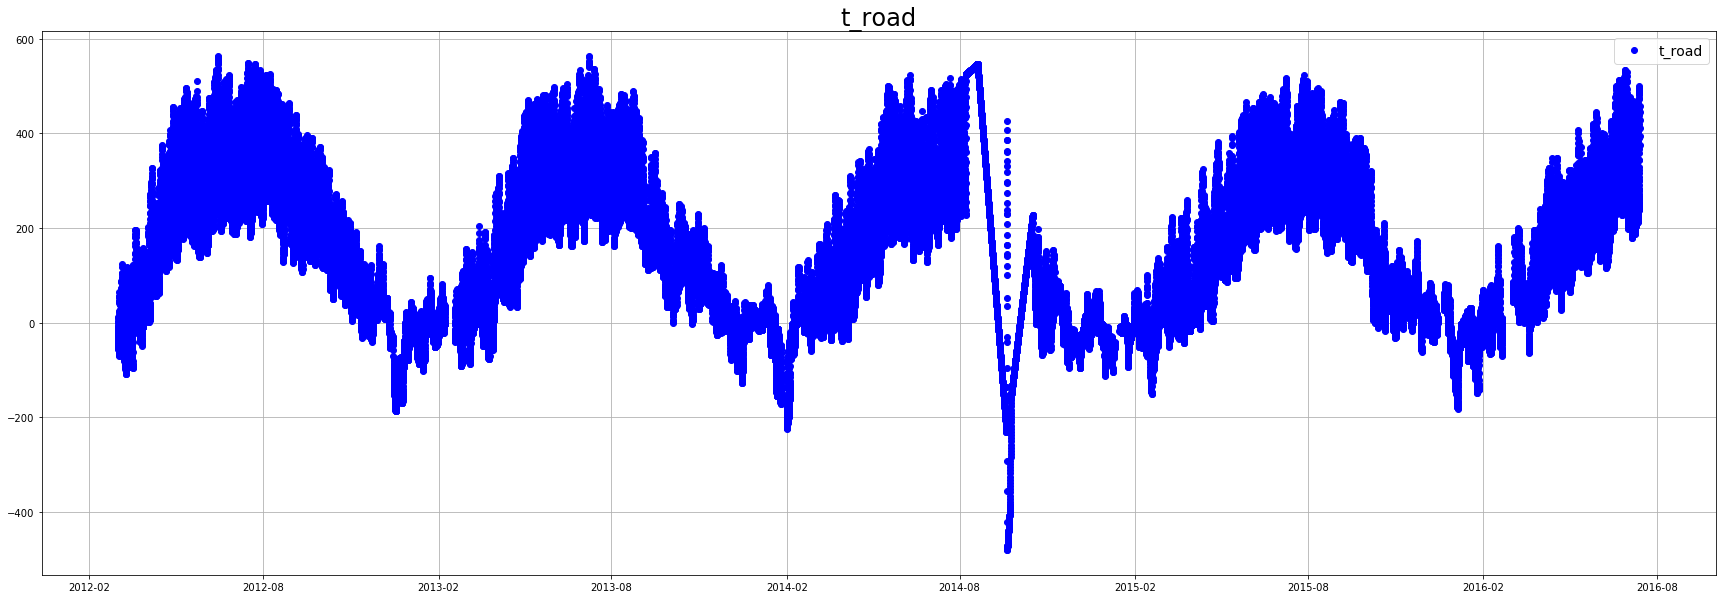

In [159]:
station = 505
start = '2012-01-01'
end = '2016-09-01'
sensor = 't_road'
plot_data(z, station, start, end, sensor)

In [157]:
to_add = z[z['station_id']==station]
to_add = to_add[(to_add['date_time'] <= end) & (to_add['date_time'] >= start)]
print(to_add['date_time'].min(), to_add['date_time'].max())
clean_data.append(to_add)

2016-06-01 00:00:00 2016-07-13 19:30:00


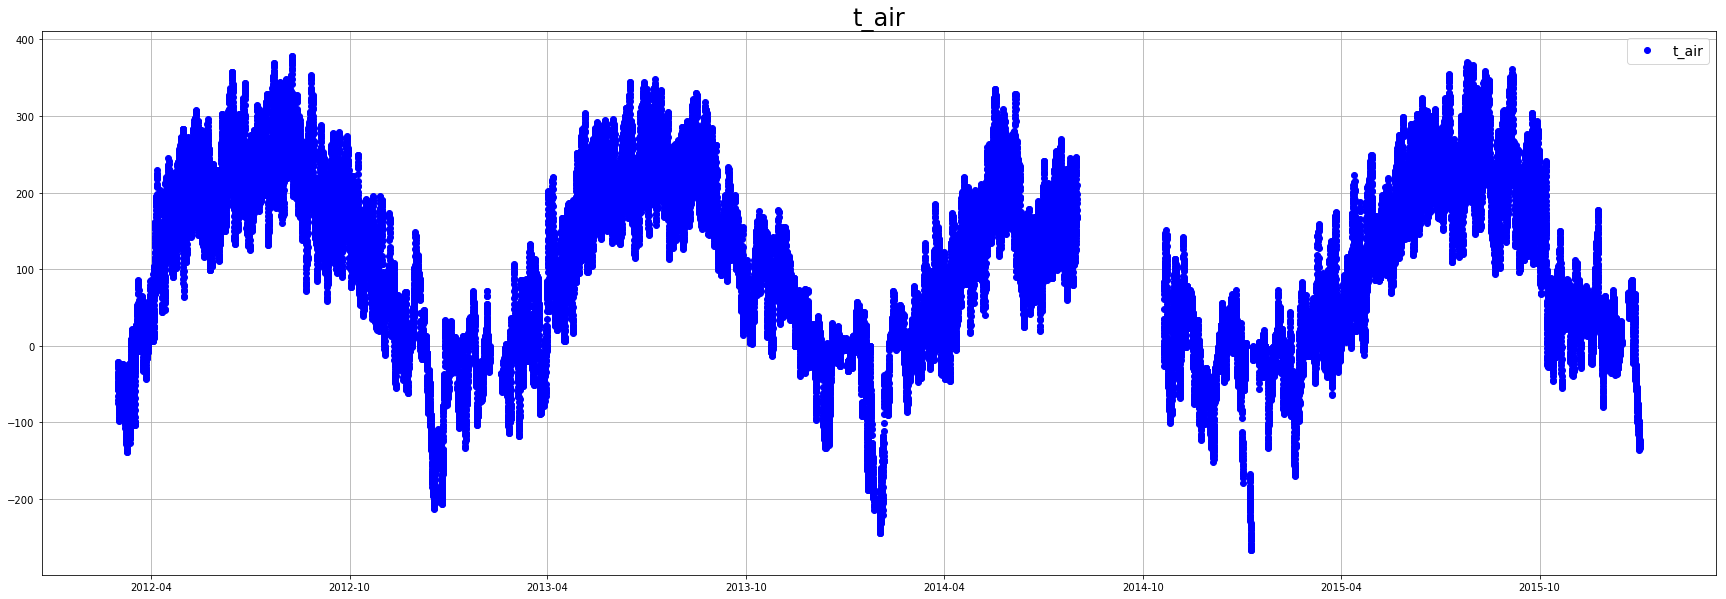

In [158]:
x = pd.concat(clean_data)
plot_data(x, station=504)

In [160]:
x.station_id.unique()

array([442, 502, 503, 504])

In [161]:
#df = pd.read_csv('clean_data.csv', )
df = pd.read_csv('clean_data.csv', header=[0, 1], skipinitialspace=True, tupleize_cols=True, index_col=0)
columns = [(elem[0], '') if elem[0] in ('date_time', 'station_id') else elem for elem in df.columns]
df.columns = pd.MultiIndex.from_tuples(columns)
df[('date_time', '')] = pd.to_datetime(df[('date_time', '')])

In [ ]:
new_clean = pd.concat((df, x))

In [ ]:
new_clean.station_id.unique()

In [163]:
new_clean.to_csv('clean_data.csv')

In [562]:
patterns_interpolated = preprocessor.CreatePatternList(df, min_length=pd.Timedelta('0h'))
patterns_solar = AddSolarAngles(patterns_interpolated)
patterns_lagged = preprocessor.CreateLaggedTable(patterns_solar)

/home/ndsviriden/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  from ipykernel import kernelapp as app


In [563]:
from Filters import create_xgb_matrix 

final = pd.concat(patterns_lagged)
test_label = 't_road'

train = final[final[('date_time', 0)] < '2015-06']
val = final[final[('date_time', 0)] >= '2015-06']

dtrain = create_xgb_matrix(train, test_label)
dval = create_xgb_matrix(val, test_label)
dfinal = create_xgb_matrix(final, test_label)

In [567]:
from sklearn.metrics import mean_squared_error as mse
import xgboost as xgb
from functools import partial
from Filters import quantile_huber_loss, quantile_huber_obj

params = {}

params["eval_metric"] = 'mae'
params["eta"] = 0.05
params["lambda"] = 0.3
params["subsample"] = 0.8 #1
params["min_child_weight"] = 1.
params["colsample_bytree"] = 0.5
params["max_depth"] = 9
params["silent"] = 1
params["gamma"] = 0.1
delta = 1.
#delta = 1.
watchlist = [(dtrain, 'train'), (dval, 'valid')]

#-----------------------------------------------------------------------------------------------
print('-----------MEDIAN-----------')

params["subsample"] = subsample
clf = xgb.train(params, dtrain, 400, watchlist, verbose_eval=20)

-----------MEDIAN-----------
[0]	train-mae:121.142	valid-mae:138.127
[20]	train-mae:43.6135	valid-mae:49.714
[40]	train-mae:15.8865	valid-mae:18.2631
[60]	train-mae:6.28368	valid-mae:7.73344
[80]	train-mae:3.3805	valid-mae:4.98108
[100]	train-mae:2.64233	valid-mae:4.38062
[120]	train-mae:2.43902	valid-mae:4.2112
[140]	train-mae:2.36186	valid-mae:4.14233
[160]	train-mae:2.32075	valid-mae:4.10982
[180]	train-mae:2.29046	valid-mae:4.07257
[200]	train-mae:2.26735	valid-mae:4.05469
[220]	train-mae:2.24516	valid-mae:4.03475
[240]	train-mae:2.22526	valid-mae:4.02303
[260]	train-mae:2.20306	valid-mae:4.00022
[280]	train-mae:2.18329	valid-mae:3.99139
[300]	train-mae:2.16479	valid-mae:3.98165
[320]	train-mae:2.14516	valid-mae:3.96568
[340]	train-mae:2.12887	valid-mae:3.95847
[360]	train-mae:2.11295	valid-mae:3.94762
[380]	train-mae:2.09561	valid-mae:3.93575
